In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
match_df=pd.read_csv("/content/drive/MyDrive/DHVKPK/IPL_Matches_2008_2022.csv")
balls_df=pd.read_csv("/content/drive/MyDrive/DHVKPK/IPL_Ball_by_Ball_2008_2022.csv")
match_df['Season'] = match_df['Season'].replace({
    '2007/08': '2008',
    '2009/10': '2010',
    '2020/21': '2020',
})
print('Season Unique',sorted(match_df['Season'].unique()))
match_df['Margin'] = match_df['Margin'].fillna(-1).astype(int) #NaN and NO result convert to -1
print('Margin NULL count ::',match_df['Margin'].isnull().sum())

match_df['Date'] = pd.to_datetime(match_df['Date'])
match_df['Margin'] = match_df['Margin'].astype(int)
match_df['Season'] = match_df['Season'].astype(int)

for df in [match_df, balls_df]:
    df.replace({
        'M.Chinnaswamy Stadium':'M Chinnaswamy Stadium',#regexp typo
        'Feroz Shah Kotla':'Arun Jaitley Stadium', #renamed in 2019
    'Rajasthan Royals': 'RR',
    'Royal Challengers Bangalore': 'RCB',
    'Delhi Daredevils': 'DD',    'Delhi Capitals': 'DC',
    'Kings XI Punjab': 'KXIP',    'Punjab Kings': 'PBKS',
    'Chennai Super Kings': 'CSK',
    'Kolkata Knight Riders': 'KKR',
    'Mumbai Indians': 'MI',
    'Sunrisers Hyderabad': 'SRH',
    'Deccan Chargers': 'Dec',
    'Gujarat Lions': 'GL',      'Gujarat Titans': 'GT',
    'Rising Pune Supergiants': 'RPS',        'Rising Pune Supergiant': 'RPS',
    'Pune Warriors': 'PW',
    'Kochi Tuskers Kerala': 'KTK',
    'Lucknow Super Giants': 'LSG',
    'Final':'F',    'Qualifier 1':'Q1',    'Qualifier 2':'Q2',
    'Eliminator':'E',    'No Result':'NR','Elimination Final':'E'

},inplace=True)

Season Unique ['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']
Margin NULL count :: 0


In [7]:
no_result_matches = match_df[match_df['WonBy'] == 'NoResults']['ID'].tolist()
print(no_result_matches)   # [1178424, 829813, 829763, 501265]
rows_to_drop = balls_df[balls_df['ID'].isin(no_result_matches)].index
balls_df.drop(rows_to_drop, inplace=True)

[1178424, 829813, 829763, 501265]


In [8]:
# 0.1>> 1.1 and 19.1>>20.1
balls_df['overs'] = balls_df['overs'] + 1
#drop No Result matches
match_df = match_df[match_df['WonBy'] != 'NoResults'].copy()
#drop no result matches' delieveries
no_result_matches = match_df[match_df['WonBy'] == 'NoResults']['ID'].tolist()
print(no_result_matches)   # [1178424, 829813, 829763, 501265]
rows_to_drop = balls_df[balls_df['ID'].isin(no_result_matches)].index
balls_df.drop(rows_to_drop, inplace=True)
#fill non DLS matches with method-0
match_df['method'] = match_df['method'].fillna(0)


#Venue missing values filled
def venue_fill(x):
    if x == 'Dubai International Cricket Stadium':
        return 'Dubai'
    if x == 'Sharjah Cricket Stadium':
        return 'Sharjah'
    else:
      return None
match_df.loc[match_df['City'].isnull(), 'City'] = match_df.loc[match_df['City'].isnull(), 'Venue'].apply(venue_fill)

#drop non-striker col
balls_df.drop(['non-striker'], axis=1, inplace=True)
#WonByWickets , WonByRuns created
match_df['WonByWickets'] = 0
match_df['WonByRuns'] = 0

for index, row in match_df.iterrows():
    if row['WonBy'] == 'Wickets':
        match_df.loc[index, 'WonByWickets'] = row['Margin']
    elif row['WonBy'] == 'Runs':
        match_df.loc[index, 'WonByRuns'] = row['Margin']
match_df.info();balls_df.info()

match_df.drop(['WonBy','Margin'], axis=1, inplace=True)
print(balls_df.isnull().sum())
print(match_df.isnull().sum())


#venue , issue solved
def clean_venue_name(venue):
    if ',' in venue:
        return venue.split(',')[0].strip()
    else:
        return venue.strip()

match_df['Venue'] = match_df['Venue'].apply(clean_venue_name)
match_df.replace('Punjab Cricket Association IS Bindra Stadium','Punjab Cricket Association Stadium',inplace=True)#mullanpur stadiun not used until 2024/23
import pandas as pd

# Define a list of changes to be made
changes = [
    {'date': '10-05-19', 'old_value': 'Qualifier', 'new_value': 'Q2'},
    {'date': '07-05-19', 'old_value': 'Qualifier', 'new_value': 'Q1'},
    {'date': '25-05-18', 'old_value': 'Qualifier', 'new_value': 'Q2'},
    {'date': '22-05-18', 'old_value': 'Qualifier', 'new_value': 'Q1'},
    {'date': '22-04-10', 'old_value': 'Semi Final', 'new_value': 'Q2'},
    {'date': '21-04-10', 'old_value': 'Semi Final', 'new_value': 'Q1'},
    {'date': '23-05-09', 'old_value': 'Semi Final', 'new_value': 'Q2'},
    {'date': '22-05-09', 'old_value': 'Semi Final', 'new_value': 'Q1'},
    {'date': '31-05-08', 'old_value': 'Semi Final', 'new_value': 'Q2'},
    {'date': '30-05-08', 'old_value': 'Semi Final', 'new_value': 'Q1'}
]
for change in changes:
    # Convert the date format
    date_object = pd.to_datetime(change['date'], format='%d-%m-%y')
    # Filter
    mask = match_df['Date'] == date_object
    match_df.loc[mask, 'MatchNumber'] = match_df.loc[mask, 'MatchNumber'].str.replace(change['old_value'], change['new_value'], regex=False)

# from collections import Counter
# venue_list=match_df['Venue'].tolist()
# venue_count=Counter(venue_list)
# print(venue_count)
# print(match_df['Venue'].nunique())

match_df.to_csv('/content/drive/My Drive/DHVKPK/IPL_Matches.csv', index=False)
balls_df.to_csv('/content/drive/My Drive/DHVKPK/IPL_Balls.csv', index=False)
cdf = pd.merge(match_df,balls_df, how="outer")

[]
<class 'pandas.core.frame.DataFrame'>
Index: 946 entries, 0 to 949
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID               946 non-null    int64         
 1   City             946 non-null    object        
 2   Date             946 non-null    datetime64[ns]
 3   Season           946 non-null    int64         
 4   MatchNumber      946 non-null    object        
 5   Team1            946 non-null    object        
 6   Team2            946 non-null    object        
 7   Venue            946 non-null    object        
 8   TossWinner       946 non-null    object        
 9   TossDecision     946 non-null    object        
 10  SuperOver        946 non-null    object        
 11  WinningTeam      946 non-null    object        
 12  WonBy            946 non-null    object        
 13  Margin           946 non-null    int64         
 14  method           946 non-null    object     

In [9]:
match_df['City'].unique()

array(['Ahmedabad', 'Kolkata', 'Mumbai', 'Navi Mumbai', 'Pune', 'Dubai',
       'Sharjah', 'Abu Dhabi', 'Delhi', 'Chennai', 'Hyderabad',
       'Visakhapatnam', 'Chandigarh', 'Bengaluru', 'Jaipur', 'Indore',
       'Bangalore', 'Kanpur', 'Rajkot', 'Raipur', 'Ranchi', 'Cuttack',
       'Dharamsala', 'Kochi', 'Nagpur', 'Johannesburg', 'Centurion',
       'Durban', 'Bloemfontein', 'Port Elizabeth', 'Kimberley',
       'East London', 'Cape Town'], dtype=object)

In [10]:
print(match_df.columns)
print(balls_df.columns)

Index(['ID', 'City', 'Date', 'Season', 'MatchNumber', 'Team1', 'Team2',
       'Venue', 'TossWinner', 'TossDecision', 'SuperOver', 'WinningTeam',
       'method', 'Player_of_Match', 'Team1Players', 'Team2Players', 'Umpire1',
       'Umpire2', 'WonByWickets', 'WonByRuns'],
      dtype='object')
Index(['ID', 'innings', 'overs', 'ballnumber', 'batter', 'bowler',
       'extra_type', 'batsman_run', 'extras_run', 'total_run', 'non_boundary',
       'isWicketDelivery', 'player_out', 'kind', 'fielders_involved',
       'BattingTeam'],
      dtype='object')


In [11]:
match_df.head()


,ID,City,Date,Season,MatchNumber,Team1,Team2,Venue,TossWinner,TossDecision,SuperOver,WinningTeam,method,Player_of_Match,Team1Players,Team2Players,Umpire1,Umpire2,WonByWickets,WonByRuns
0,1312200,Ahmedabad,2022-05-29,2022,F,RR,GT,Narendra Modi Stadium,RR,bat,N,GT,0,HH Pandya,"['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...","['WP Saha', 'Shubman Gill', 'MS Wade', 'HH Pan...",CB Gaffaney,Nitin Menon,7,0
1,1312199,Ahmedabad,2022-05-27,2022,Q2,RCB,RR,Narendra Modi Stadium,RR,field,N,RR,0,JC Buttler,"['V Kohli', 'F du Plessis', 'RM Patidar', 'GJ ...","['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...",CB Gaffaney,Nitin Menon,7,0
2,1312198,Kolkata,2022-05-25,2022,E,RCB,LSG,Eden Gardens,LSG,field,N,RCB,0,RM Patidar,"['V Kohli', 'F du Plessis', 'RM Patidar', 'GJ ...","['Q de Kock', 'KL Rahul', 'M Vohra', 'DJ Hooda...",J Madanagopal,MA Gough,0,14
3,1312197,Kolkata,2022-05-24,2022,Q1,RR,GT,Eden Gardens,GT,field,N,GT,0,DA Miller,"['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...","['WP Saha', 'Shubman Gill', 'MS Wade', 'HH Pan...",BNJ Oxenford,VK Sharma,7,0
4,1304116,Mumbai,2022-05-22,2022,70,SRH,PBKS,Wankhede Stadium,SRH,bat,N,PBKS,0,Harpreet Brar,"['PK Garg', 'Abhishek Sharma', 'RA Tripathi', ...","['JM Bairstow', 'S Dhawan', 'M Shahrukh Khan',...",AK Chaudhary,NA Patwardhan,5,0


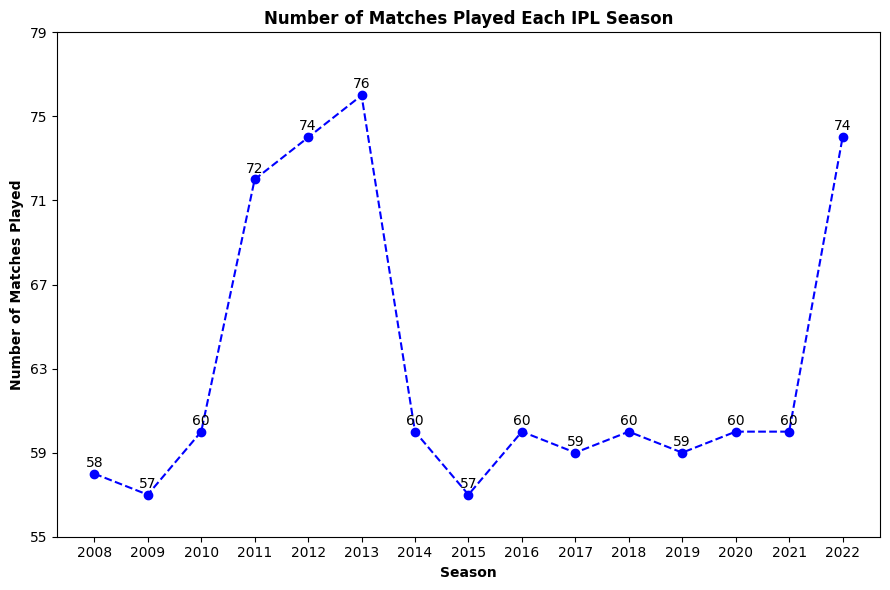

In [12]:
matches_per_season = match_df['Season'].value_counts().sort_index()
#line plot
plt.figure(figsize=(9,6))
plt.plot(matches_per_season.index, matches_per_season.values, marker='o', linestyle='--', color='b')

# Add value labels near each point
for x, y in zip(matches_per_season.index, matches_per_season.values):
    plt.annotate(str(y), xy=(x, y), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=10)

plt.xlabel("Season",fontweight='bold')
plt.ylabel("Number of Matches Played",fontweight='bold')
plt.title("Number of Matches Played Each IPL Season",fontweight='bold')
plt.yticks(np.arange(55, 80, 4))
plt.xticks(matches_per_season.index)

plt.tight_layout()
plt.show()

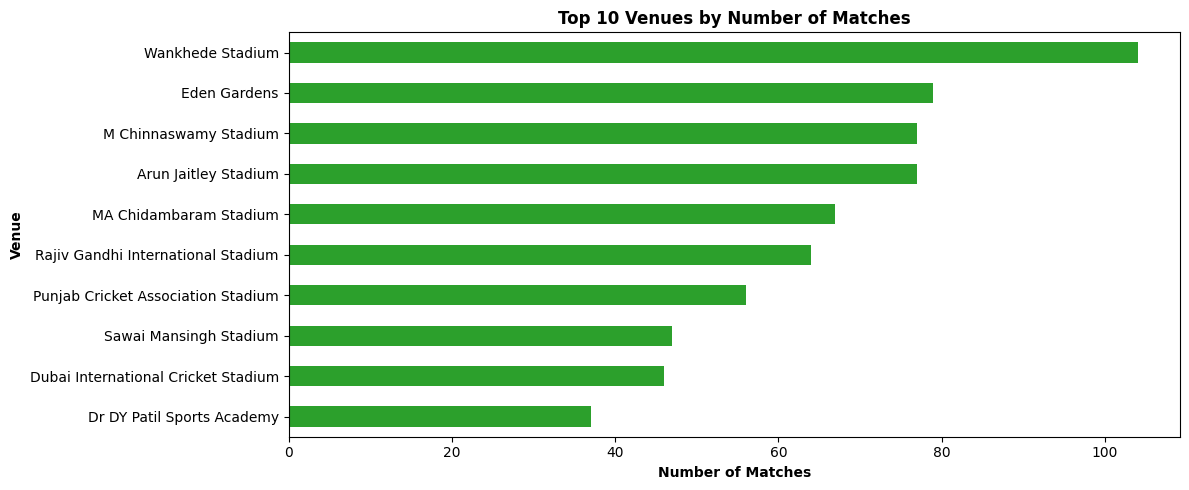

In [13]:
plt.figure(figsize=(12,5))
match_df['Venue'].value_counts().sort_values().tail(10).plot(kind='barh', color='#2ca02c')
plt.title('Top 10 Venues by Number of Matches',fontweight='bold')
plt.xlabel('Number of Matches',fontweight='bold')
plt.ylabel('Venue', fontweight='bold')
plt.tight_layout()
plt.show()


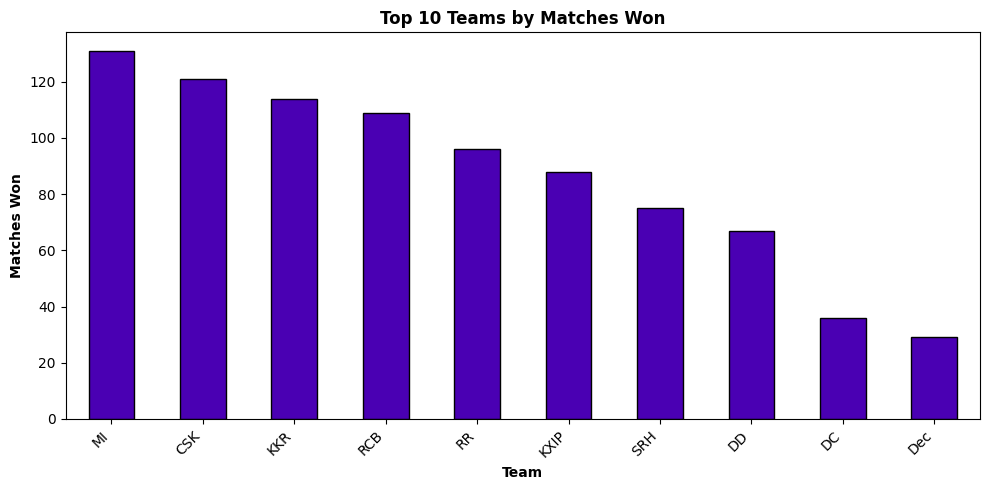

In [14]:
plt.figure(figsize=(10,5))
match_df['WinningTeam'].value_counts().head(10).plot(kind='bar', color='#4a00b3',edgecolor='black')
plt.title('Top 10 Teams by Matches Won',fontweight='bold')
plt.ylabel('Matches Won',fontweight='bold')
plt.xlabel('Team',fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



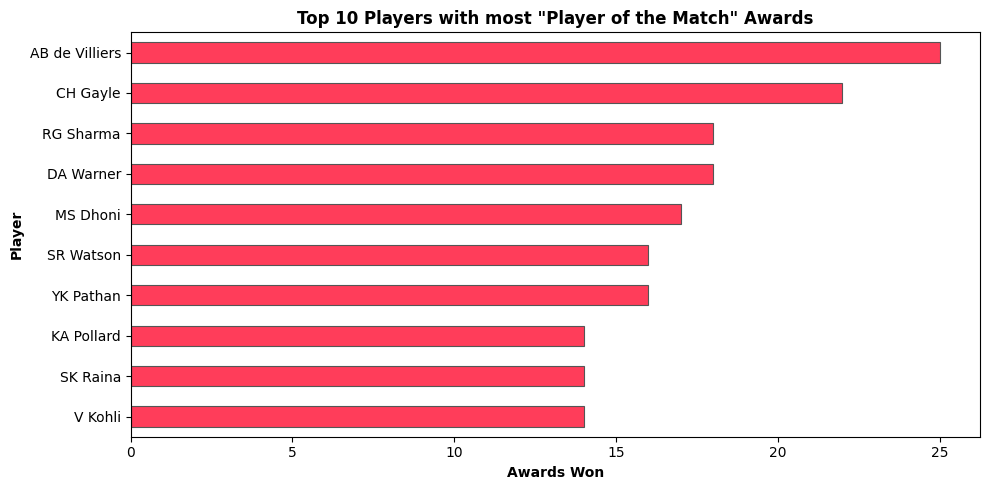

In [15]:
plt.figure(figsize=(10,5))
match_df['Player_of_Match'].value_counts().sort_values().tail(10).plot(kind='barh', color='#ff3d5a',edgecolor='#555555',linewidth=0.8)
plt.title('Top 10 Players with most "Player of the Match" Awards',fontweight='bold')
plt.xlabel('Awards Won',fontweight='bold')
plt.ylabel('Player',fontweight='bold')
plt.tight_layout()
plt.show()


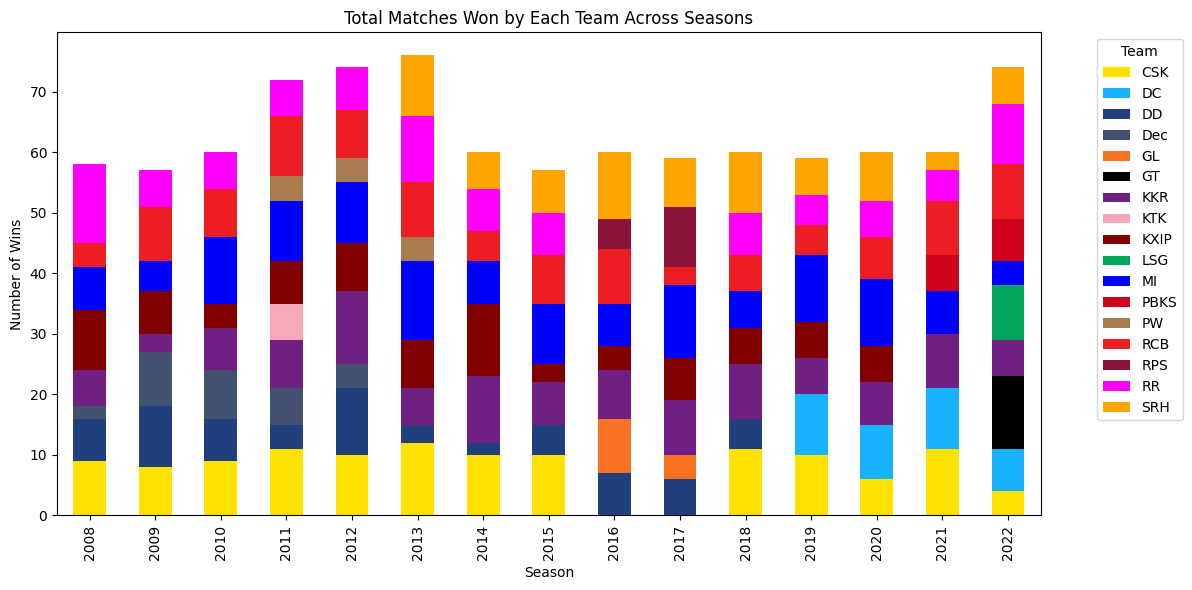

In [16]:
team_season = match_df.groupby(['Season', 'WinningTeam']).size().unstack().fillna(0)

# Get the unique teams in the order they appear in the legend
teams = team_season.columns.tolist()
team_colors = {
'PBKS' : '#D0021B',    # Deep crimson (Punjab Kings)[6]
'Dec'  : '#425170',    # Deccan Chargers (historic, dark steel blue)
'RPS'  : '#8A1538',    # Rising Pune Supergiant (maroon/purple variant)
'PW'   : '#A97C50',    # Pune Warriors (brown/gold variant)
'KTK'  : '#F7A8B8',    # Kochi Tuskers Kerala (light pink)
'LSG'  : '#00A65D',    # Lucknow Super Giants (lush green)[6]
'GT'   : 'black',    # Gujarat Titans (navy blue)[6]
'MI'   : 'blue',    # Deep blue (Mumbai Indians)[3][6]
'CSK'  : '#ffe300',    # Bright yellow (Chennai Super Kings)[4][6]
'RCB'  : '#ED1D24',    # Intense red (Royal Challengers Bangalore)[2][6]
'KKR'  : '#702082',    # Royal purple (Kolkata Knight Riders)[2][6]
'DC'   : '#19B2FF',    # Cool blue (Delhi Capitals, distinct from MI)[5][6]
'RR'   : 'magenta',    # Playful pink (Rajasthan Royals)[6]
'SRH'  : 'orange',    # Warm orange (Sunrisers Hyderabad)[2][6]
'DD'   : '#213F7D',    # Dark blue (Delhi Daredevils, different from MI)[5]
'GL'   : '#F97324',    # Gujarat Lions (navy, based on Gujarat Titans)[6]
'KXIP' : 'maroon',
}


colors = [team_colors[team] for team in teams]

# Plot with the color list
team_season.plot(kind='bar', stacked=True, figsize=(12,6), color=colors)

plt.title('Total Matches Won by Each Team Across Seasons')
plt.xlabel('Season')
plt.ylabel('Number of Wins')
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 59.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 56.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 48.1% of the points cannot be place

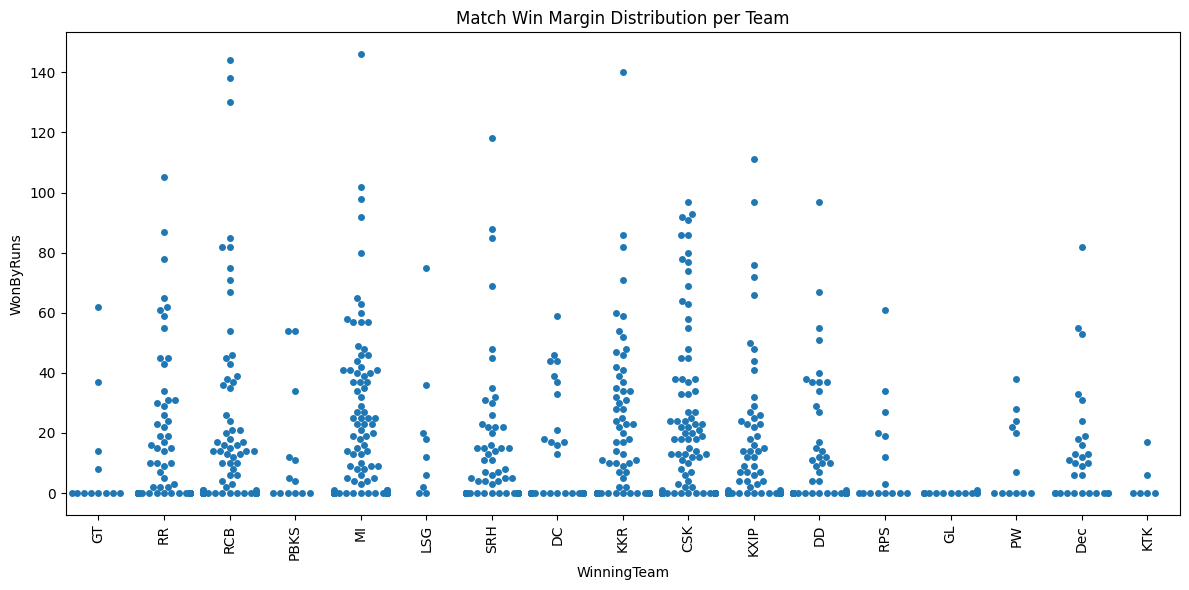

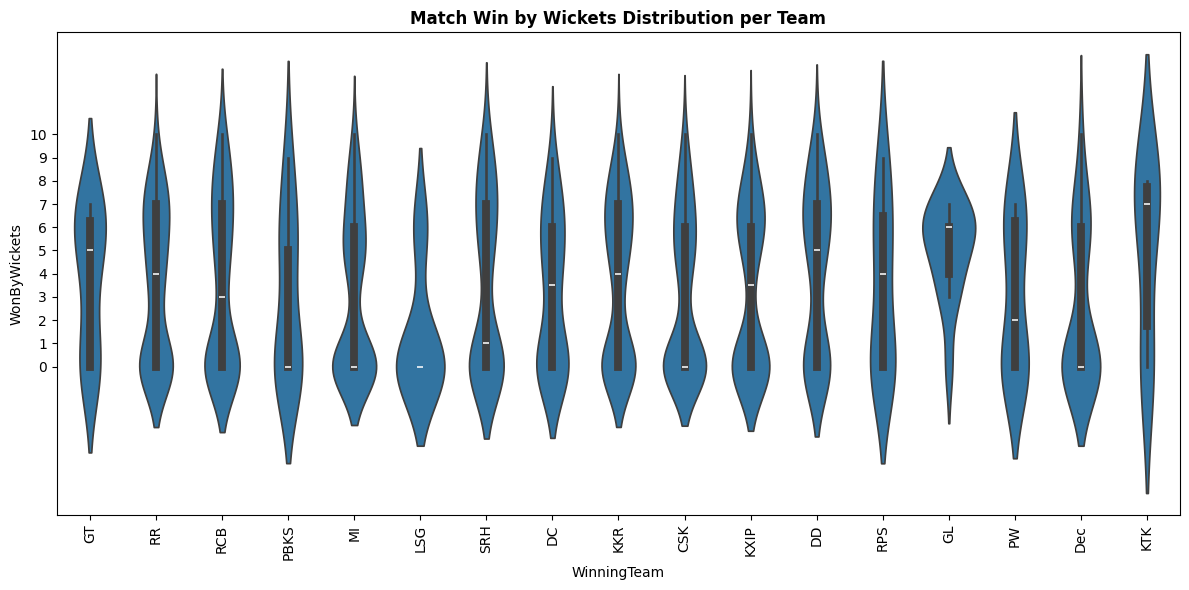

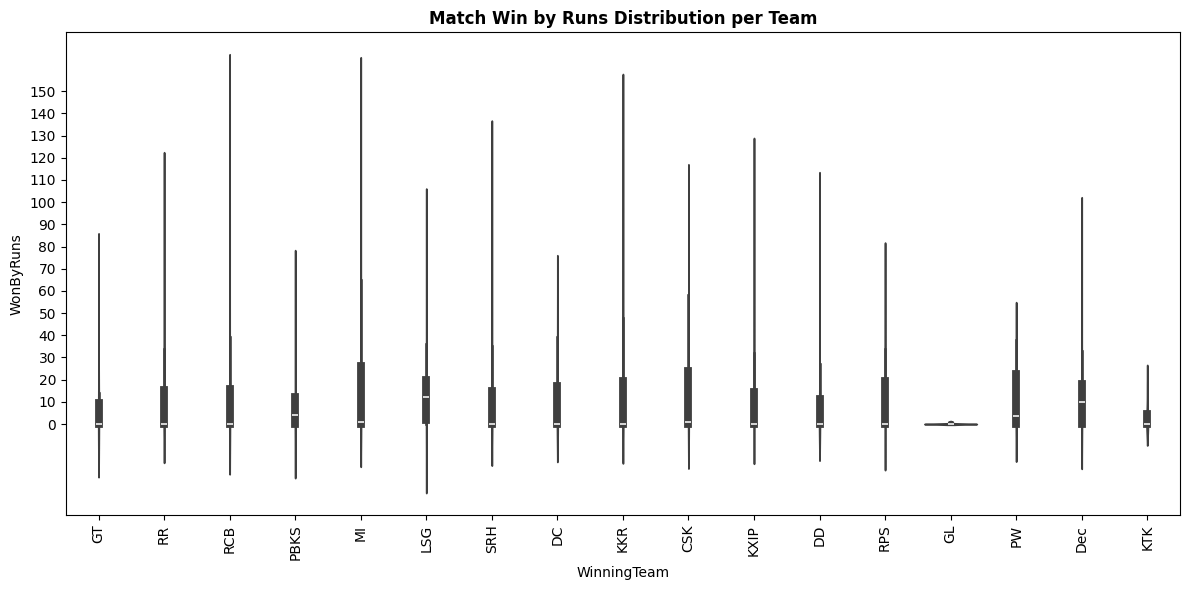

In [17]:
plt.figure(figsize=(12,6))
sns.swarmplot(data=match_df, x='WinningTeam', y='WonByRuns')
plt.xticks(rotation=90)
plt.title('Match Win Margin Distribution per Team')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.violinplot(data=match_df, x='WinningTeam', y='WonByWickets')
plt.xticks(rotation=90)
plt.title('Match Win by Wickets Distribution per Team',fontweight='bold')
plt.yticks(np.arange(0, match_df['WonByWickets'].max() + 1, 1))
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
sns.violinplot(data=match_df, x='WinningTeam', y='WonByRuns')
plt.xticks(rotation=90)
plt.title('Match Win by Runs Distribution per Team',fontweight='bold')
plt.yticks(np.arange(0, match_df['WonByRuns'].max() + 10, 10))
plt.tight_layout()
plt.show()

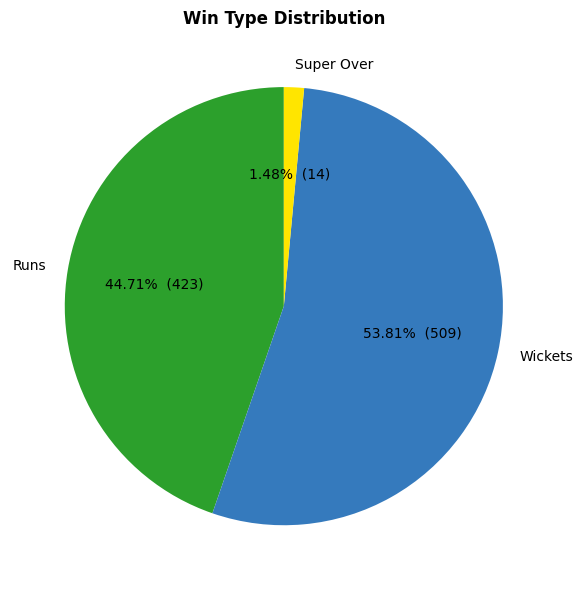

In [61]:
import matplotlib.pyplot as plt

win_by_runs = match_df[match_df['WonByRuns'] > 0]['ID'].count()
win_by_wickets = match_df[match_df['WonByWickets'] > 0]['ID'].count()
win_by_super_over = match_df[match_df['SuperOver'] == 'Y']['ID'].count()
labels = ['Runs', 'Wickets', 'Super Over']
values = [win_by_runs, win_by_wickets, win_by_super_over]

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.figure(figsize=(6, 6))
plt.pie(
    values,
    labels=labels,
    autopct=make_autopct(values),
    startangle=90,
    colors=['#2ca02c', '#357abd', '#ffe500'],
)

plt.title('Win Type Distribution', fontweight='bold')
plt.tight_layout()
plt.show()

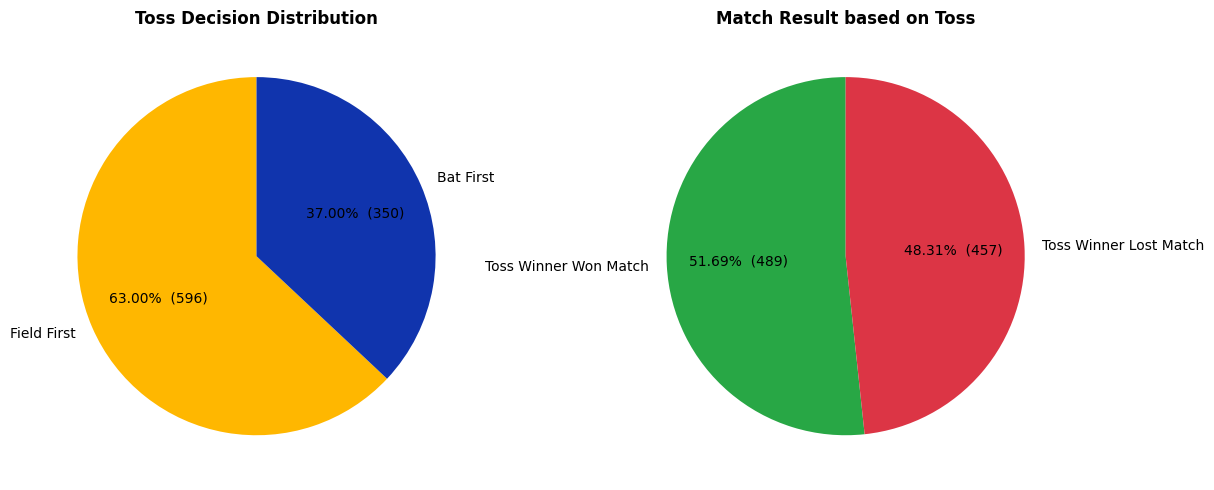

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

toss_decision_counts = match_df['TossDecision'].value_counts()

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct, v=val)
    return my_autopct

wedges, texts, autotexts = axes[0].pie(
    toss_decision_counts,
    labels=['Field First', 'Bat First'],
    autopct=make_autopct(toss_decision_counts.values),
    colors=['#ffb700', '#1034ad'],
    startangle=90,
    wedgeprops={'linewidth': 2}
)
axes[0].set_title('Toss Decision Distribution', fontweight='bold')

toss_winner_match_winner = (match_df['TossWinner'] == match_df['WinningTeam']).sum()
toss_winner_match_loser = (match_df['TossWinner'] != match_df['WinningTeam']).sum()

labels = ['Toss Winner Won Match', 'Toss Winner Lost Match']
values = [toss_winner_match_winner, toss_winner_match_loser]

wedges, texts, autotexts = axes[1].pie(
    values,
    labels=labels,
    autopct=make_autopct(values),
    startangle=90,
    colors=['#28a745', '#dc3545']  # Green for win, Red for loss
)
axes[1].set_title('Match Result based on Toss', fontweight='bold')

plt.tight_layout()
plt.show()


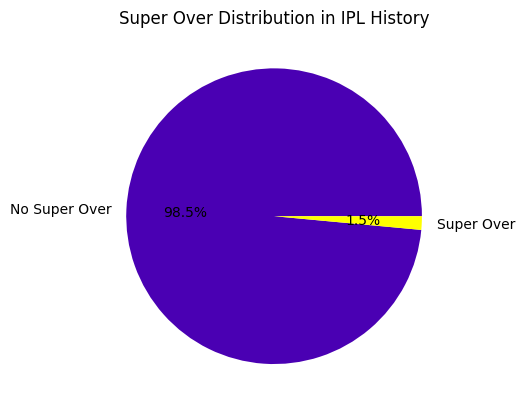

In [23]:
super_over_counts = match_df['SuperOver'].value_counts()
super_over_counts.plot.pie(autopct='%1.1f%%', labels=['No Super Over', 'Super Over'], colors=['#4a00b3','yellow'])
plt.title('Super Over Distribution in IPL History')
plt.ylabel('')
plt.show()

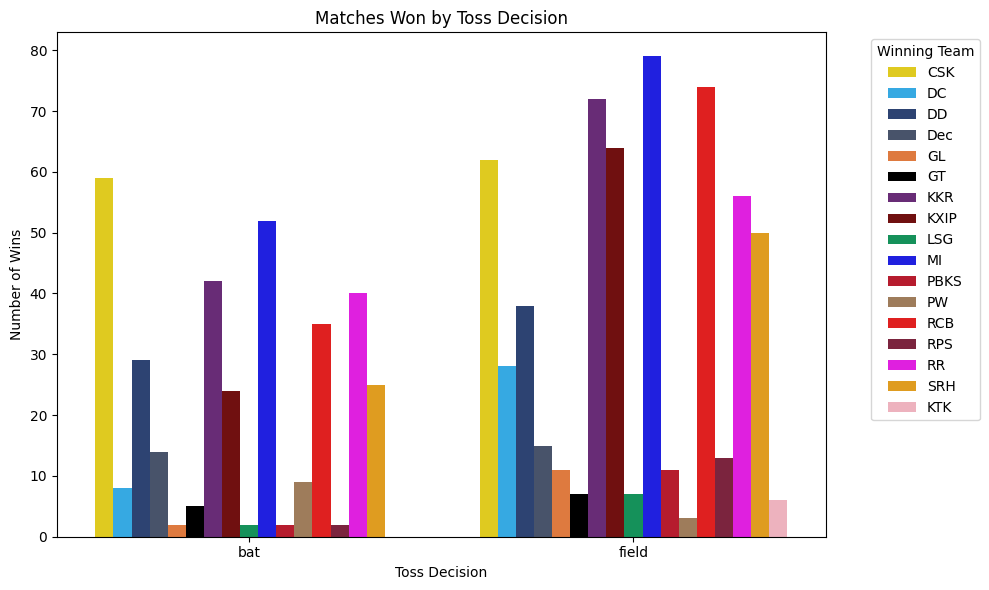

In [24]:
toss_win_counts = match_df.groupby(['TossDecision', 'WinningTeam']).size().reset_index(name='Wins')

team_colors = {
    'MI': 'blue',
    'CSK': '#ffe300',
    'RCB': 'red',
    'KKR': '#702082',
    'DC': '#19B2FF',
    'RR': 'magenta',
    'SRH': 'orange',
    'DD': '#213F7D',
    'GL': '#F97324',
    'KXIP': 'maroon',
    'PBKS': '#D0021B',
    'Dec': '#425170',
    'RPS': '#8A1538',
    'PW': '#A97C50',
    'KTK': '#F7A8B8',
    'LSG': '#00A65D',
    'GT': 'black'
}
plt.figure(figsize=(10, 6))
sns.barplot(x='TossDecision', y='Wins', hue='WinningTeam', data=toss_win_counts, palette=team_colors)
plt.title('Matches Won by Toss Decision')
plt.xlabel('Toss Decision')
plt.ylabel('Number of Wins')
plt.legend(title='Winning Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

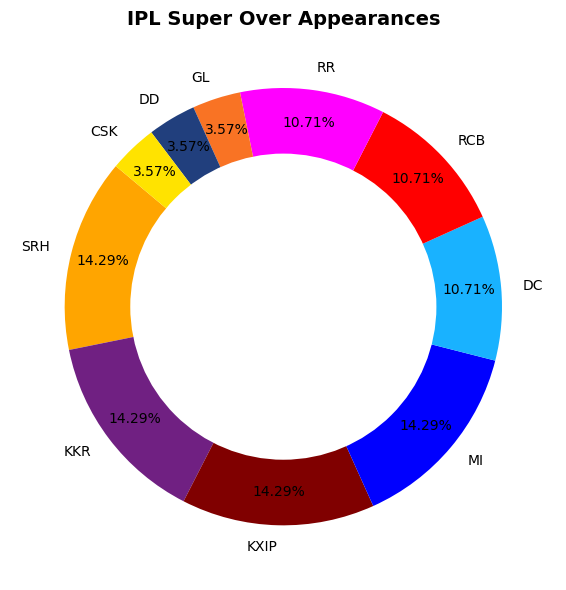

In [25]:
team_colors = {
'MI'   : 'blue',
'CSK'  : '#ffe300',
'RCB'  : 'red',
'KKR'  : '#702082',
'DC'   : '#19B2FF',
'RR'   : 'magenta',
'SRH'  : 'orange',
'DD'   : '#213F7D',
'GL'   : '#F97324',
'KXIP' : 'maroon',
}
def plot_superover(team_counts, title="IPL Teams Distribution"):
    fig, ax = plt.subplots(figsize=(10, 6))

    wedges, texts, autotexts = ax.pie(
        team_counts.values,
        labels=team_counts.index,
        autopct='%1.2f%%',
        startangle=140,
        pctdistance=0.85,
        colors=colors
    )

    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig.gca().add_artist(centre_circle)
    ax.set_title(title, fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

super_over_teams = match_df[match_df['SuperOver'] == 'Y'][['Team1', 'Team2']].values.ravel()
team_counts = pd.Series(super_over_teams).value_counts()
teams = team_counts.index.tolist()
colors = [team_colors[team] for team in teams]
plot_superover(team_counts, title="IPL Super Over Appearances")


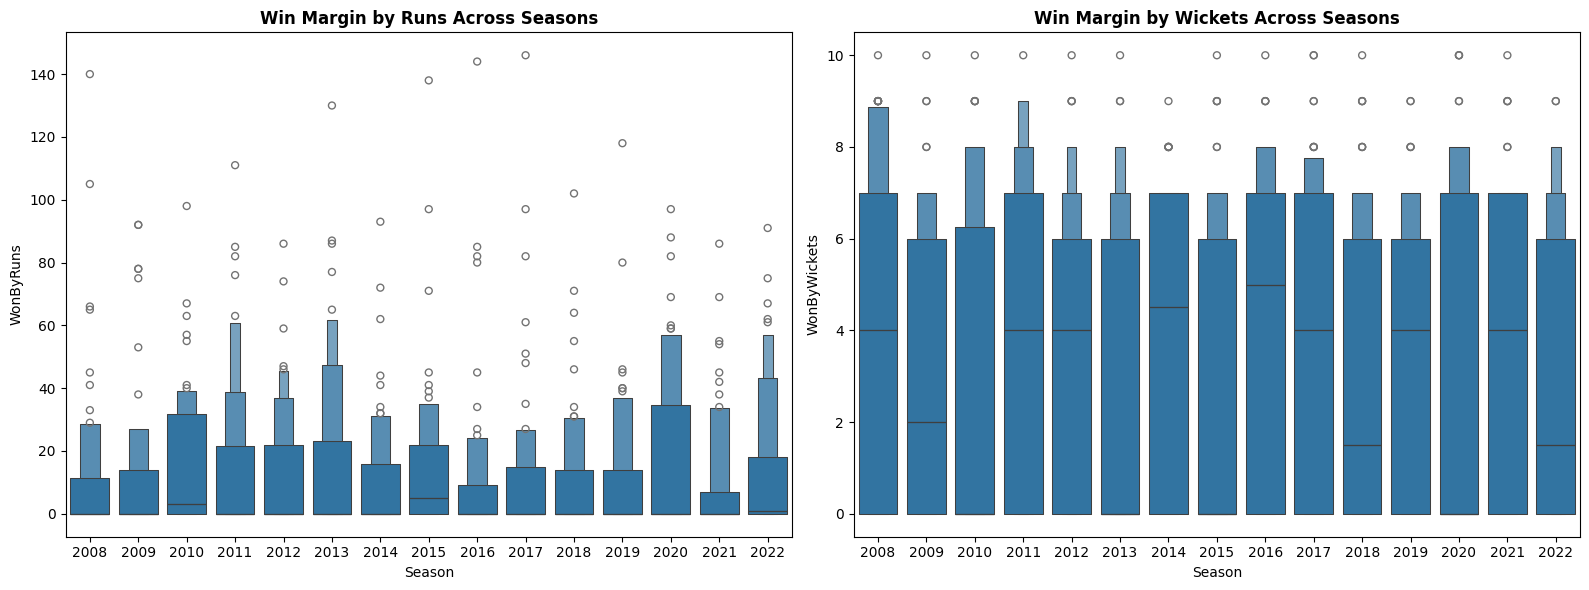

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
#Win Margin by Runs
sns.boxenplot(data=match_df, x='Season', y='WonByRuns', ax=axes[0])
axes[0].set_title('Win Margin by Runs Across Seasons',fontweight='bold')

#Win Margin by Wickets
sns.boxenplot(data=match_df, x='Season', y='WonByWickets', ax=axes[1])
axes[1].set_title('Win Margin by Wickets Across Seasons',fontweight='bold')

plt.tight_layout()
plt.show()

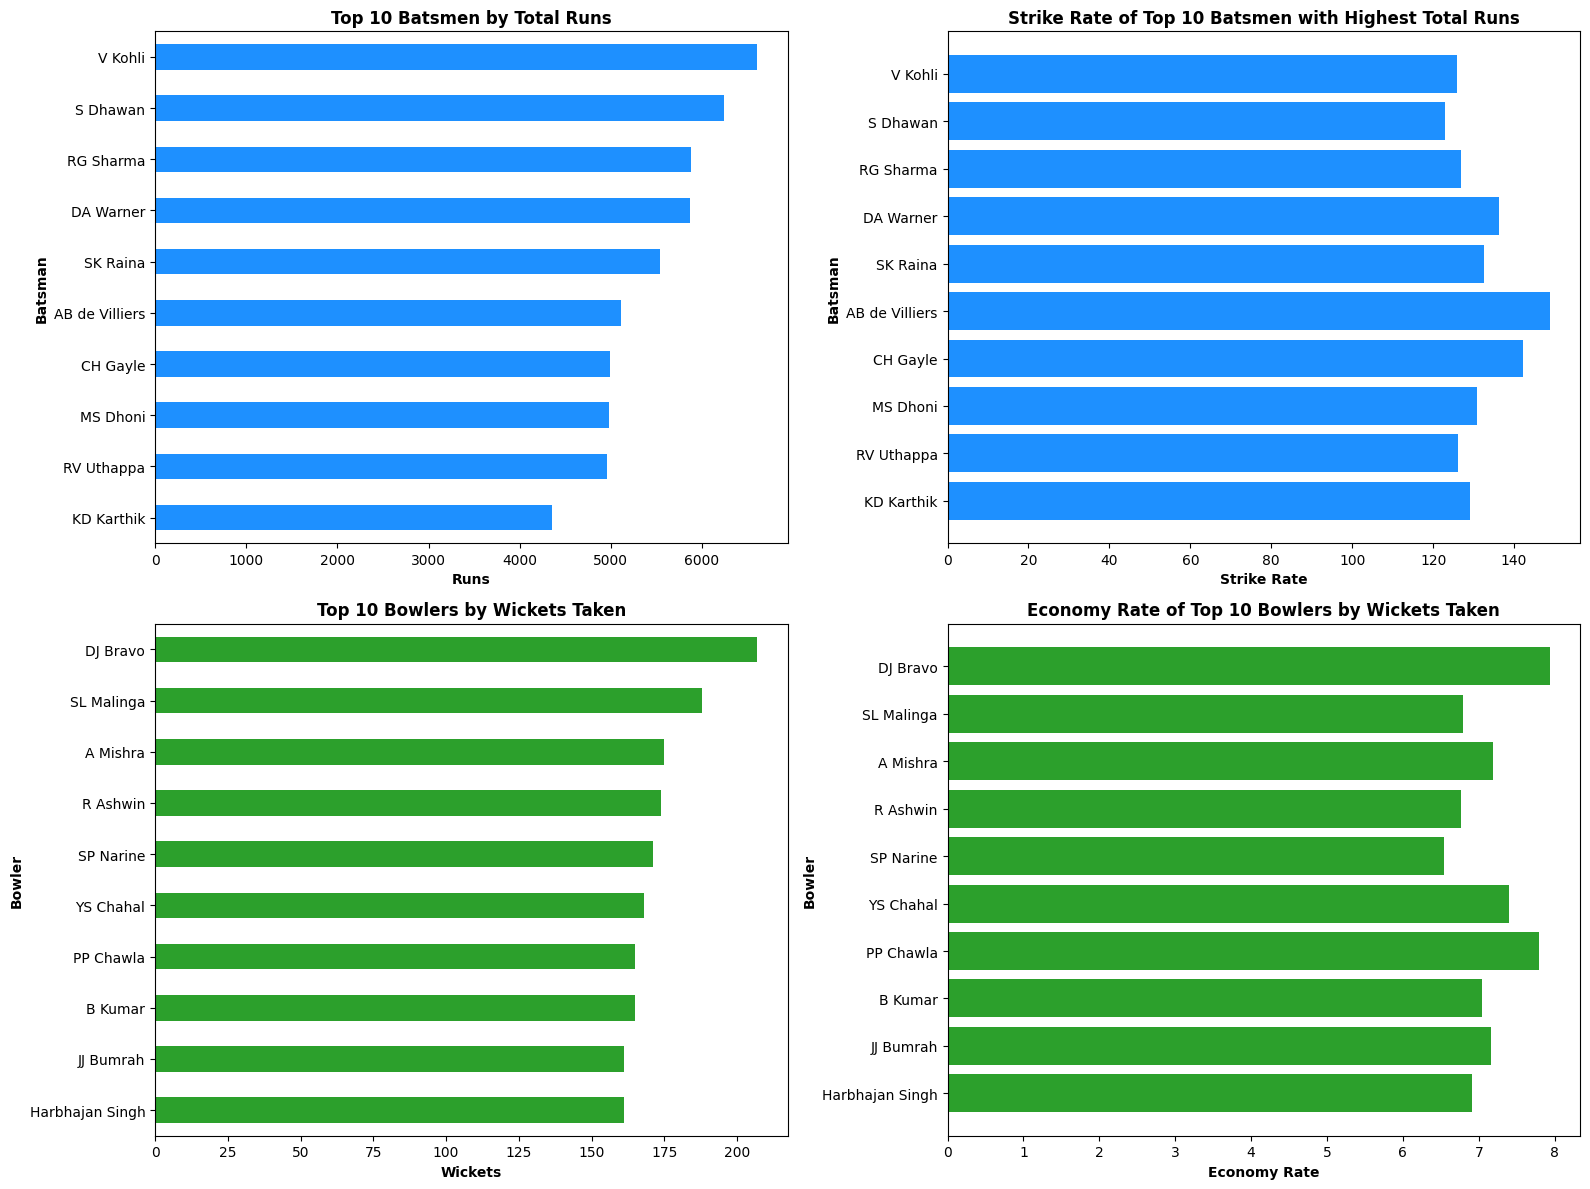

In [27]:

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

#Top 10 Batsmen by Total Runs
cdf.groupby('batter')['batsman_run'].sum().sort_values().tail(10).plot(kind='barh', color='dodgerblue', ax=axes[0, 0])
axes[0, 0].set_title('Top 10 Batsmen by Total Runs', fontweight='bold')
axes[0, 0].set_xlabel('Runs', fontweight='bold')
axes[0, 0].set_ylabel('Batsman', fontweight='bold')

#Strike Rate of Top 10 Batsmen
batsman_stats = (cdf.groupby('batter')
                   .agg({'batsman_run': 'sum', 'ballnumber': 'count'})
                   .assign(strike_rate=lambda x: (x['batsman_run'] / x['ballnumber']) * 100))
top_10_batsmen_runs = batsman_stats.sort_values('batsman_run', ascending=False).head(10)
axes[0, 1].barh(top_10_batsmen_runs.index, top_10_batsmen_runs['strike_rate'], color='dodgerblue')
axes[0, 1].set_title('Strike Rate of Top 10 Batsmen with Highest Total Runs', fontweight='bold')
axes[0, 1].set_xlabel('Strike Rate', fontweight='bold')
axes[0, 1].set_ylabel('Batsman', fontweight='bold')
axes[0, 1].invert_yaxis()

#Top 10 Bowlers by Wickets Taken
top_10_bowlers = (cdf[cdf['isWicketDelivery'] == 1]
                     .groupby('bowler')
                     .size()
                     .sort_values()
                     .tail(10)
                     .index
                     .tolist())
cdf[cdf['isWicketDelivery'] == 1].groupby('bowler').size().sort_values().tail(10).plot(kind='barh', color='#2ca02c', ax=axes[1, 0])#forestgreens
axes[1, 0].set_title('Top 10 Bowlers by Wickets Taken', fontweight='bold')
axes[1, 0].set_xlabel('Wickets', fontweight='bold')
axes[1, 0].set_ylabel('Bowler', fontweight='bold')

#Economy Rate of Top 10 Bowlers
bowler_stats = (cdf[cdf['bowler'].isin(top_10_bowlers)]
                   .groupby('bowler')
                   .agg({'batsman_run': 'sum', 'ballnumber': 'count'})
                   .assign(
                       extra_runs=lambda x: cdf[(cdf['bowler'].isin(top_10_bowlers)) & (cdf['extra_type'].isin(['noballs', 'wides']))]
                                       .groupby('bowler')['extras_run'].sum(),
                       economy_rate=lambda x: ((x['batsman_run'] + x['extra_runs']) / (x['ballnumber'] / 6))
                   ))
bowler_stats = bowler_stats.reindex(top_10_bowlers)
axes[1, 1].barh(bowler_stats.index, bowler_stats['economy_rate'], color='#2ca02c')
axes[1, 1].set_title('Economy Rate of Top 10 Bowlers by Wickets Taken', fontweight='bold')
axes[1, 1].set_xlabel('Economy Rate', fontweight='bold')
axes[1, 1].set_ylabel('Bowler', fontweight='bold')

plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

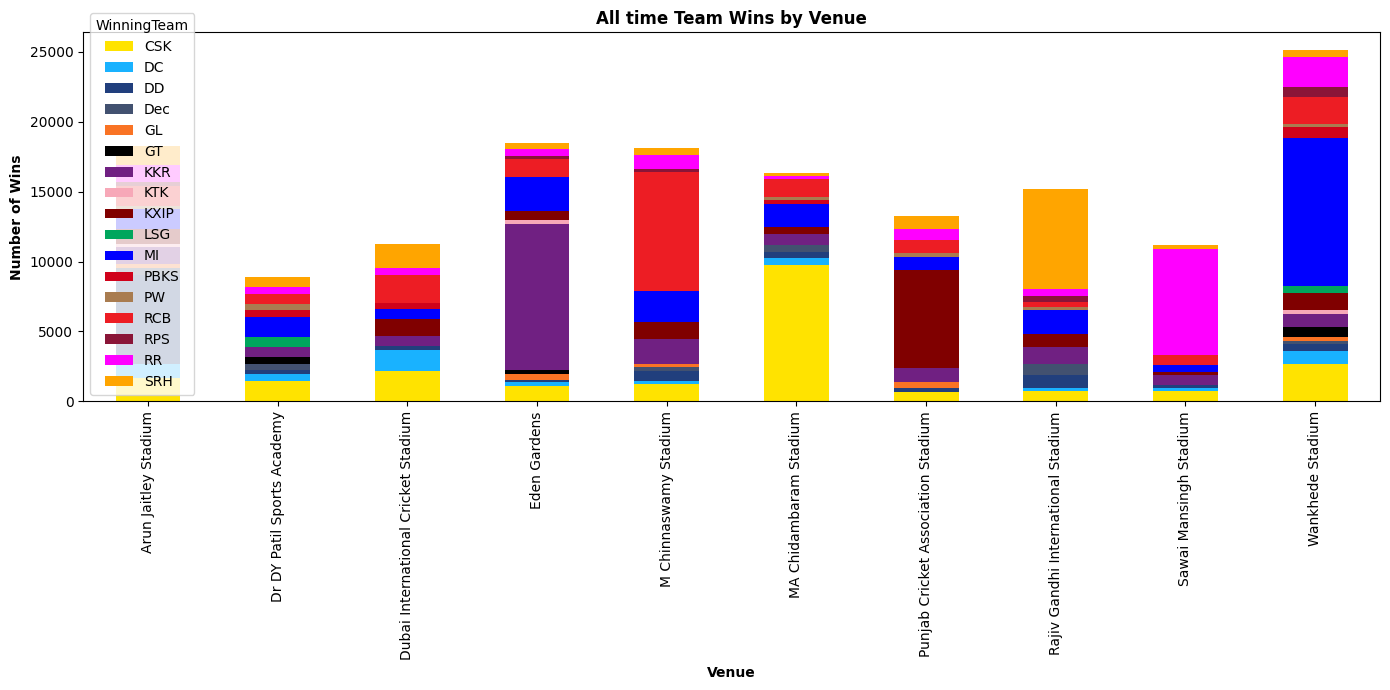

In [29]:
teams = team_season.columns.tolist()
team_colors = {
'PBKS' : '#D0021B',
'Dec'  : '#425170',
'RPS'  : '#8A1538',
'PW'   : '#A97C50',
'KTK'  : '#F7A8B8',
'LSG'  : '#00A65D',
'GT'   : 'black',
'MI'   : 'blue',
'CSK'  : '#ffe300',
'RCB'  : '#ED1D24',
'KKR'  : '#702082',
'DC'   : '#19B2FF',
'RR'   : 'magenta',
'SRH'  : 'orange',
'DD'   : '#213F7D',
'GL'   : '#F97324',
'KXIP' : 'maroon',
}

top_10_venues = match_df['Venue'].value_counts().head(10).index.tolist()
cdf_top10venue = cdf[cdf['Venue'].isin(top_10_venues)]
colors = [team_colors[team] for team in teams]
plt.figure(figsize=(14,7))
team_performance = cdf_top10venue.groupby(['Venue', 'WinningTeam']).size().unstack().fillna(0)
team_performance.plot(kind='bar', stacked=True,
                      color=colors,
                      figsize=(14,7))
plt.title('All time Team Wins by Venue',fontweight='bold')
plt.ylabel('Number of Wins',fontweight='bold')
plt.xlabel('Venue',fontweight='bold')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



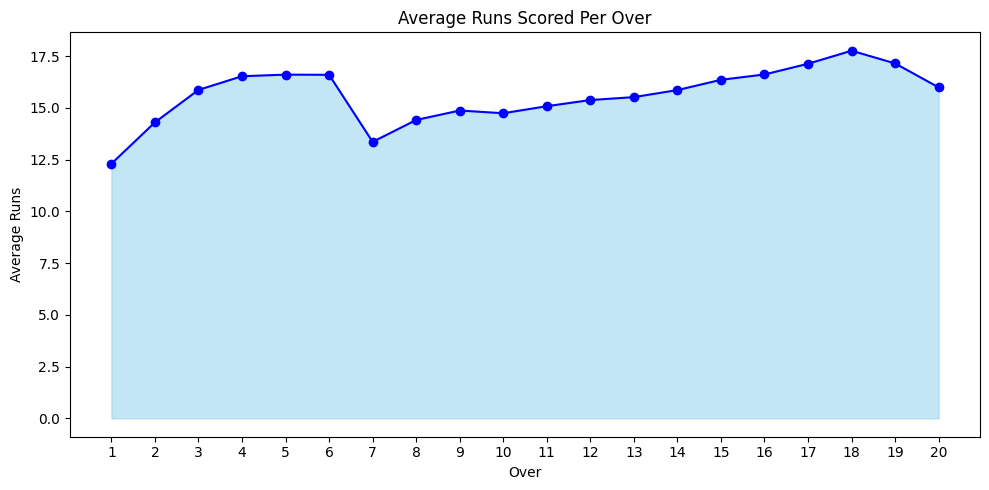

In [35]:
plt.figure(figsize=(10, 5))
total_matches = cdf['ID'].nunique()
avg_runs_per_over = cdf.groupby('overs')['total_run'].sum() / total_matches
plt.fill_between(avg_runs_per_over.index, avg_runs_per_over.values, color='skyblue', alpha=0.5)
plt.plot(avg_runs_per_over.index, avg_runs_per_over.values, marker='o', color='b')
plt.title('Average Runs Scored Per Over')
plt.xlabel('Over')
plt.xticks(range(1, 21))
plt.ylabel('Average Runs')
plt.tight_layout()
plt.show()


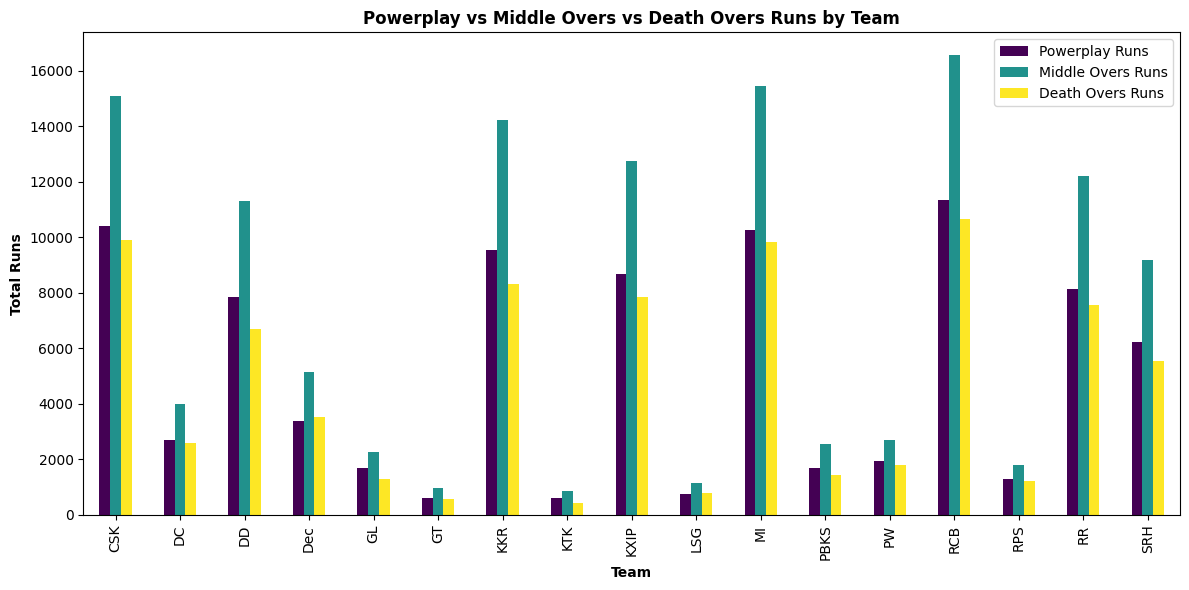

In [32]:
# (overs 1-6)
powerplay_runs = cdf[cdf['overs'] <= 6].groupby('Team1')['total_run'].sum()

# (overs 7-15)
middle_overs_runs = cdf[(cdf['overs'] >= 7) & (cdf['overs'] <= 15)].groupby('Team1')['total_run'].sum()

# (overs 16-20)
death_overs_runs = cdf[(cdf['overs'] >= 16) & (cdf['overs'] <= 20)].groupby('Team1')['total_run'].sum()

runs_comparison = pd.DataFrame({
    'Powerplay Runs': powerplay_runs,
    'Middle Overs Runs': middle_overs_runs,
    'Death Overs Runs': death_overs_runs
}).fillna(0)

runs_comparison.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title('Powerplay vs Middle Overs vs Death Overs Runs by Team',fontweight='bold')
plt.ylabel('Total Runs',fontweight='bold')
plt.xlabel('Team',fontweight='bold')
plt.tight_layout()
plt.show()


In [36]:
balls = balls_df.copy()
matches = match_df.copy()


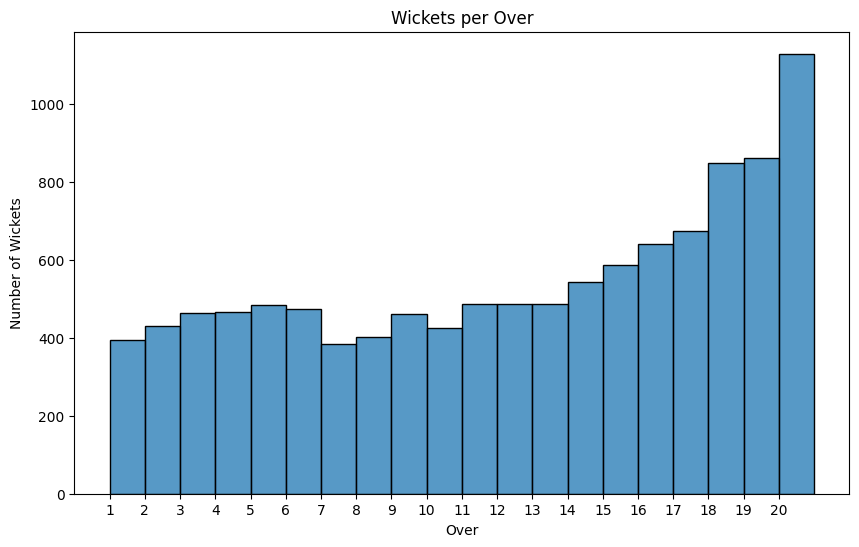

In [37]:
wicket_overs = balls[balls['isWicketDelivery'] == 1]['overs']
plt.figure(figsize=(10, 6))
sns.histplot(wicket_overs, bins=range(1, 22), kde=False)
plt.title('Wickets per Over')
plt.xlabel('Over', ha='center')
plt.xticks(range(1,21), ha='center')
plt.ylabel('Number of Wickets')
plt.show()

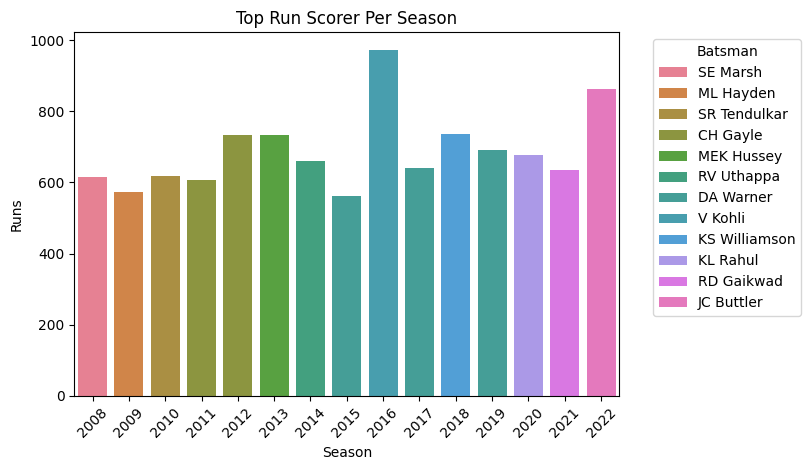

In [49]:
matches['Season'] = matches['Date'].dt.year.astype(str)
balls_with_season = balls.merge(matches[['ID', 'Season']], on='ID')
season_batters = balls_with_season.groupby(['Season', 'batter'])['batsman_run'].sum().reset_index()
top_per_season = season_batters.sort_values(['Season', 'batsman_run'], ascending=[True, False]).groupby('Season').head(1)

sns.barplot(data=top_per_season, x='Season', y='batsman_run', hue='batter')
plt.title('Top Run Scorer Per Season')
plt.ylabel('Runs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Batsman', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

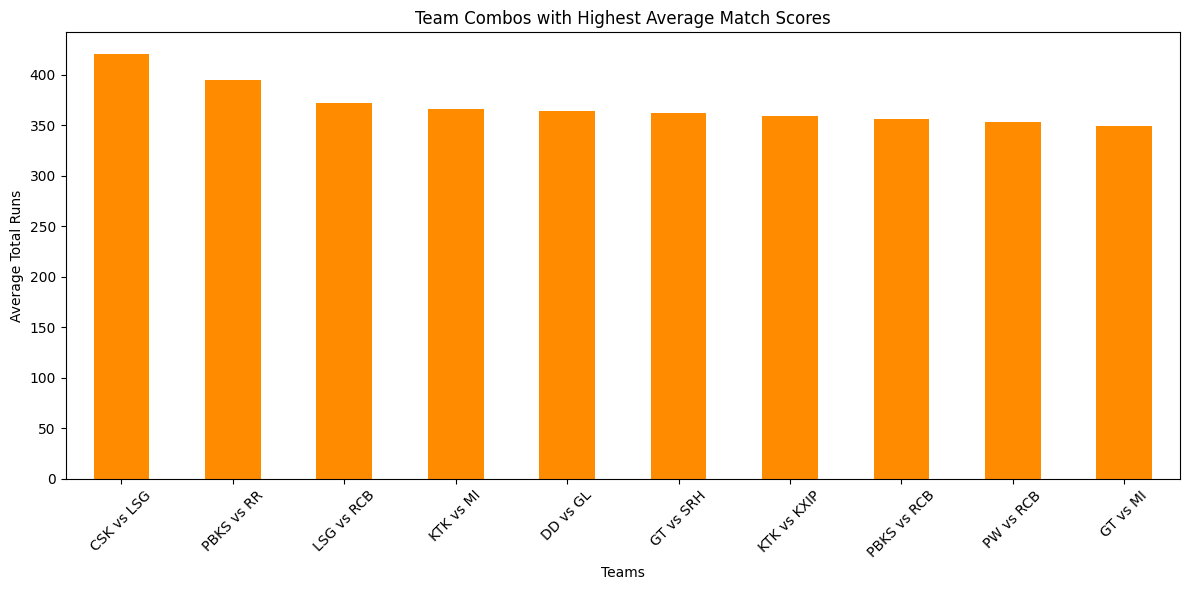

In [39]:
match_scores = balls.groupby('ID')['total_run'].sum().reset_index()
team_combos = matches[['ID', 'Team1', 'Team2']].copy()
team_combos['Teams'] = team_combos.apply(lambda row: ' vs '.join(sorted([row['Team1'], row['Team2']])), axis=1)
combo_scores = match_scores.merge(team_combos[['ID', 'Teams']], on='ID')
avg_scores = combo_scores.groupby('Teams')['total_run'].mean().sort_values(ascending=False).head(10)

avg_scores.plot(kind='bar', figsize=(12, 6), color='darkorange')
plt.title('Team Combos with Highest Average Match Scores')
plt.ylabel('Average Total Runs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


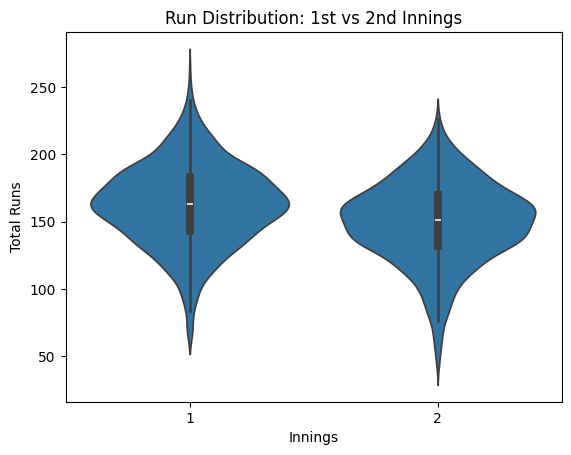

In [40]:
innings_runs = balls.groupby(['ID', 'innings'])['total_run'].sum().reset_index()
innings_runs = innings_runs[innings_runs['innings'].isin([1, 2])]  # Filter for innings 1 and 2
sns.violinplot(data=innings_runs, x='innings', y='total_run')
plt.title('Run Distribution: 1st vs 2nd Innings')
plt.xlabel('Innings')
plt.ylabel('Total Runs')
plt.show()

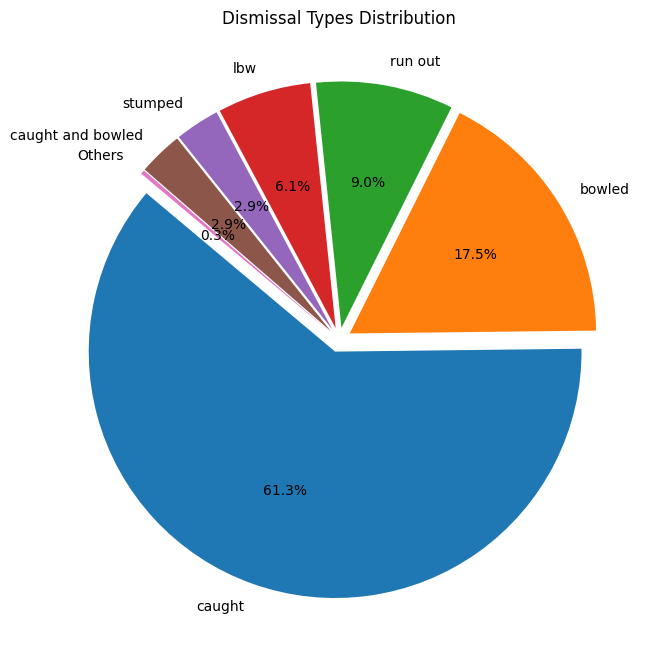

In [41]:
threshold = 0.02
dismissals_counts = balls[balls['isWicketDelivery'] == 1]['kind'].value_counts()
dismissals_percent = dismissals_counts / dismissals_counts.sum()

large_dismissals = dismissals_counts[dismissals_percent >= threshold]
small_dismissals = dismissals_counts[dismissals_percent < threshold]
dismissals_grouped = large_dismissals.copy()
if not small_dismissals.empty:
    dismissals_grouped['Others'] = small_dismissals.sum()

explode = [0.05] * len(dismissals_grouped)
dismissals_grouped.plot(
    kind='pie',
    autopct='%1.1f%%',
    figsize=(8, 8),
    startangle=140,
    explode=explode
)
plt.title('Dismissal Types Distribution')
plt.ylabel('')
plt.show()


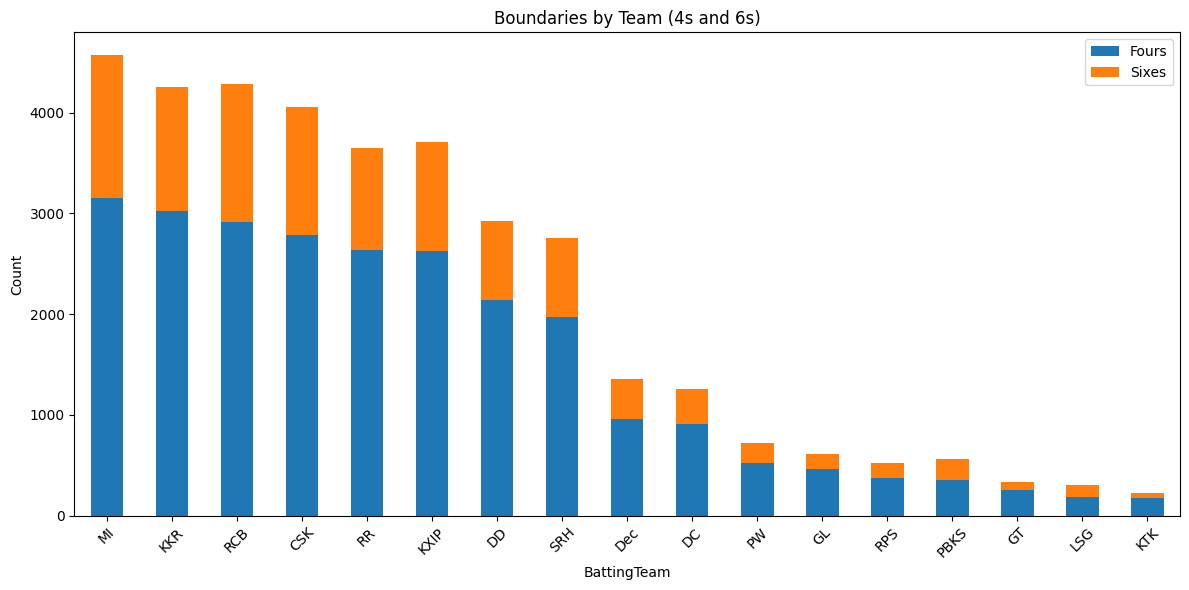

In [42]:
boundaries = balls[balls['batsman_run'].isin([4, 6])]
boundary_data = boundaries.groupby(['BattingTeam', 'batsman_run']).size().unstack().fillna(0)
boundary_data.columns = ['Fours', 'Sixes']
boundary_data.sort_values(by='Fours', ascending=False).plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Boundaries by Team (4s and 6s)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


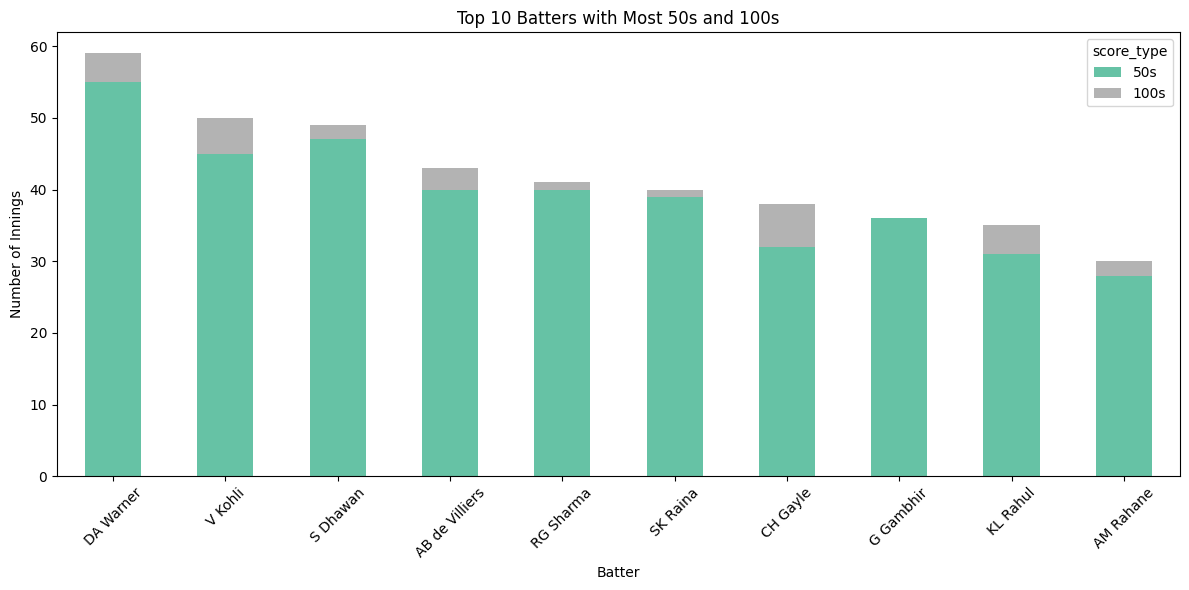

In [43]:
batter_scores = balls.groupby(['ID', 'batter'])['batsman_run'].sum().reset_index()
def classify_score(score):
    if score >= 100:
        return '100s'
    elif 50 <= score < 100:
        return '50s'
    else:
        return None
batter_scores['score_type'] = batter_scores['batsman_run'].apply(classify_score)
filtered_scores = batter_scores.dropna(subset=['score_type'])
score_counts = filtered_scores.groupby(['batter', 'score_type']).size().unstack(fill_value=0)
score_counts['total'] = score_counts.sum(axis=1)
top_batters = score_counts.sort_values(by='total', ascending=False).head(10)
top_batters[['50s', '100s']].plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')
plt.title('Top 10 Batters with Most 50s and 100s')
plt.ylabel('Number of Innings')
plt.xlabel('Batter')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
